In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

torch.manual_seed(42)

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:

class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, num_conv_layers, conv_params):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels, *conv_params) for _ in range(num_conv_layers)])
        self.batch_norms = nn.ModuleList([nn.BatchNorm2d(conv_params[0]) for _ in range(num_conv_layers)])
        out_channels = conv_params[0]
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, x):
        batch_size = x.size(0)
        channel_means = x.mean(dim=[2, 3])
        a = self.fc(channel_means)
        x_out = torch.stack([F.leaky_relu(conv(x)) for conv in self.conv_layers], dim=-1).sum(dim=-1)
        x_out = torch.stack([bn(x_out) for bn in self.batch_norms], dim=-1).sum(dim=-1)
        return x_out * F.leaky_relu(a.view(batch_size, -1, 1, 1))

In [6]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_sizes=[]):
        super(OutputBlock, self).__init__()
        self.fc_layers = nn.ModuleList([nn.Linear(in_channels, hidden_sizes[0])] + [nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)] + [nn.Linear(hidden_sizes[-1], num_classes)])
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(size) for size in hidden_sizes])

    def forward(self, x):
        channel_means = x.mean(dim=[2, 3])
        out = F.leaky_relu(channel_means)
        for fc, bn in zip(self.fc_layers, self.batch_norms):
            out = F.leaky_relu(bn(fc(out)))
        return out

In [7]:
class CustomCIFAR10Net(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCIFAR10Net, self).__init__()
        self.intermediate_blocks = nn.ModuleList([
            IntermediateBlock(3, 3, [64, 3, 3, 1, 1]),
            IntermediateBlock(64, 3, [128, 3, 3, 1, 1]),
            IntermediateBlock(128, 3, [256, 3, 3, 1, 1]),
            IntermediateBlock(256, 3, [512, 3, 3, 1, 1]),
            IntermediateBlock(512, 3, [1024, 3, 3, 1, 1])
        ])
        self.output_block = OutputBlock(1024, num_classes, [512, 256])
        self.dropout = nn.Dropout(0.5)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')


    def forward(self, x):
        for block in self.intermediate_blocks:
            x = block(x)
            x = self.dropout(x)
        x = self.output_block(x)
        return x

model = CustomCIFAR10Net()
input_data = torch.randn(batch_size, 3, 32, 32)
output = model(input_data)
print(output.shape)


torch.Size([128, 256])


In [8]:
model = CustomCIFAR10Net().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, betas=(0.8, 0.95), weight_decay=0.0005, amsgrad=True, eps=1e-8)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [10]:
train_losses = []
train_accuracies = []
test_accuracies = []

In [11]:
num_epochs = 50
total_steps = len(train_loader) * num_epochs
step_count = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step_count += 1
        if step_count % 100 == 0:
            train_losses.append(running_loss / 100)
            print(f'[Epoch: {epoch + 1}, Step: {step_count:5d}/{total_steps}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

        if i == len(train_loader) - 1:
            model.eval()
            with torch.no_grad():
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()

            train_accuracy = 100 * correct_train / total_train
            train_accuracies.append(train_accuracy)

    scheduler.step()

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}: Test Accuracy = {test_accuracy:.2f}%')

[Epoch: 1, Step:   100/19550] loss: 5.017
[Epoch: 1, Step:   200/19550] loss: 4.064
[Epoch: 1, Step:   300/19550] loss: 3.413
Epoch 1: Test Accuracy = 15.58%
[Epoch: 2, Step:   400/19550] loss: 0.234
[Epoch: 2, Step:   500/19550] loss: 2.236
[Epoch: 2, Step:   600/19550] loss: 2.067
[Epoch: 2, Step:   700/19550] loss: 1.944
Epoch 2: Test Accuracy = 27.57%
[Epoch: 3, Step:   800/19550] loss: 0.334
[Epoch: 3, Step:   900/19550] loss: 1.834
[Epoch: 3, Step:  1000/19550] loss: 1.792
[Epoch: 3, Step:  1100/19550] loss: 1.747
Epoch 3: Test Accuracy = 39.09%
[Epoch: 4, Step:  1200/19550] loss: 0.447
[Epoch: 4, Step:  1300/19550] loss: 1.669
[Epoch: 4, Step:  1400/19550] loss: 1.632
[Epoch: 4, Step:  1500/19550] loss: 1.570
Epoch 4: Test Accuracy = 46.18%
[Epoch: 5, Step:  1600/19550] loss: 0.549
[Epoch: 5, Step:  1700/19550] loss: 1.518
[Epoch: 5, Step:  1800/19550] loss: 1.515
[Epoch: 5, Step:  1900/19550] loss: 1.471
Epoch 5: Test Accuracy = 49.87%
[Epoch: 6, Step:  2000/19550] loss: 0.658


In [14]:
print("Train Losses:" + str(train_losses[-1]))
print("Last Train Accuracy:" + str(train_accuracies[-1]))
print("Last Test Accuracy:" + str(test_accuracies[-1]))

Train Losses:0.6034696349501609
Last Train Accuracy:78.116
Last Test Accuracy:74.45


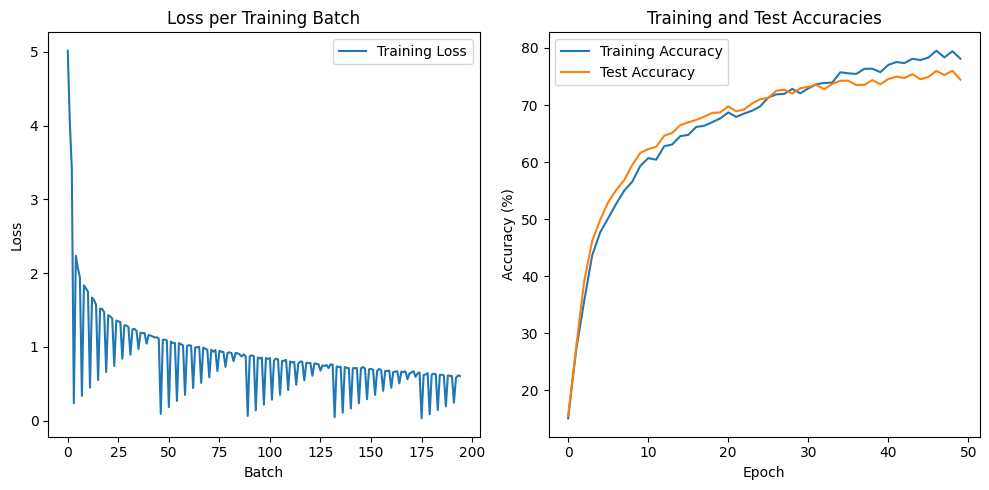

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss per Training Batch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()